# TOC

- Import
- Text proprocessing functions
- Models
    1. GloVe + Logistic
    2. Glove + Random Forest
    3. USE + Logistic
    4. USE + Random Forest
- Comparisons

# Import

## Libraries

In [2]:
# import basics
import pandas as pd
import numpy as np

# Text preprocessing
import nltk.tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import contractions
import string
punc = string.punctuation
from nltk.corpus import stopwords
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))
import spacy
nlp = spacy.load("en_core_web_md")
import en_core_web_md
nlp = en_core_web_md.load()
    
# Load the glove embeddings
import flair
from flair.data import Sentence
from flair.embeddings import WordEmbeddings
glove_embedding = WordEmbeddings('glove')
embedding_size = glove_embedding.embedding_length

# Load USE embeddings
import tensorflow as tf
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
def embed(input):
    return model(input)

# DataPreprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import evaluation
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# import visualisation
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /home/faculty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/faculty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [21]:
# /project/Phase 2/data/final_data.csv
df_raw = pd.read_csv('/project/Phase 2/data/final_data.csv',index_col=0)
df_raw.head()

,content_ps,topic_ps,type_re,topic_re,title_re,content_re,label
0,Smart textiles business KYMIRA makes sportswea...,Planning,action plans,Digital Readiness,Creating an effective remote workforce,"Remote working is nothing new, but before coro...",0.0
1,Smart textiles business KYMIRA makes sportswea...,Planning,action plans,People & Team,Improve the way you performance manage staff,"At the heart of it, performance management inv...",0.0
2,Smart textiles business KYMIRA makes sportswea...,Planning,action plans,Planning,Making an informed decision about investing in...,Investing is a big decision and many business ...,1.0
3,Smart textiles business KYMIRA makes sportswea...,Planning,action plans,Planning,Predict future trends in your market,"Market disruptors, new technology and cultural...",1.0
4,Smart textiles business KYMIRA makes sportswea...,Planning,action plans,Sales & Growth,Identifying growth opportunities in your curre...,Starting at the bottom of your sales funnel is...,1.0


# Define text pre-processing functions

## Functions for GloVe Embedding

In [18]:
def tokenisation(s):
    return word_tokenize(s.lower())

def contract(s):
    return list(map(lambda w: contractions.fix(w),s))

def puntuations(s):
    return [w for w in s if w not in punc]

def stopwords_rm(s):
    return [w for w in s if w not in STOP_WORDS]

def lemm(s):
    return [token.lemma_ for token  in nlp(' '.join(s))]

def pipe(s):
    return ' '.join(lemm(stopwords_rm(puntuations(contract(tokenisation(s))))))

def apply_pipeline(df):
    cols = ['content_ps','content_re']
    for col in cols:
        df[col] = df[col].apply(lambda row: pipe(row))
    return df

def word_embedding(s):
    sentence = Sentence(s)
    glove_embedding.embed(sentence)
    sentence_matrix = sum([np.matrix(token.embedding) for token in sentence])/len(sentence)
    return np.array(sentence_matrix).ravel()

def get_X_Y_glove(df):
    df2 = df.copy()
    cols = ['content_ps','content_re']
    for col in cols:
        df2[col] = df[col].apply(word_embedding)
    ps = pd.DataFrame(df2['content_ps'].to_list())
    re = pd.DataFrame(df2['content_re'].to_list())

    X = pd.concat([ps,re],axis=1)
    y = df['label']
    
    return X, y

## Functions for USE

In [19]:
def get_X_Y_use(df):
    
    ps = pd.DataFrame(np.array(embed(df['content_ps'])).tolist())
    re = pd.DataFrame(np.array(embed(df['content_re'])).tolist())

    X = pd.concat([ps,re],axis=1)
    y = df['label']
    
    return X, y

# Models

## Glove

In [28]:
X_glove, y_glove = get_X_Y_glove(df_raw)

In [29]:
X_glove_train, X_glove_test, y_glove_train, y_glove_test = train_test_split(X_glove, y_glove, random_state=42, train_size=0.8, stratify=y_glove)

## 1. GloVe + Logistic Regression

In [50]:
model1 = LogisticRegression(class_weight='balanced', random_state=42)
model1.fit(X_glove_train, y_glove_train)

model1_pred = model1.predict(X_glove_test)
model1_accuracy = accuracy_score(model1_pred,y_glove_test)
model1_f1 = f1_score(model1_pred,y_glove_test,average='weighted')

print('Model2\'s result on test set:')
print('The Accuracy score: {:.2f}'.format(model1_accuracy))
print('The F1-score score: {:.2f}'.format(model1_f1))

print('-'*100)
print('Model2\'s hyperparameters:')
print(model1.get_params(deep=True))

Model2's result on test set:
The Accuracy score: 0.59
The F1-score score: 0.59
----------------------------------------------------------------------------------------------------
Model2's hyperparameters:
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2. GloVe + Random Forest

In [51]:
model2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model2.fit(X_glove_train, y_glove_train)

model2_pred = model2.predict(X_glove_test)
model2_accuracy = accuracy_score(model2_pred,y_glove_test)
model2_f1 = f1_score(model2_pred,y_glove_test,average='weighted')

print('Model2\'s result on test set:')
print('The Accuracy score: {:.2f}'.format(model2_accuracy))
print('The F1-score score: {:.2f}'.format(model2_f1))

print('-'*100)
print('Model2\'s hyperparameters:')
print(model2.get_params(deep=True))

Model2's result on test set:
The Accuracy score: 0.72
The F1-score score: 0.72
----------------------------------------------------------------------------------------------------
Model2's hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## USE

In [30]:
X_use, y_use = get_X_Y_use(df_raw)

In [31]:
X_use_train, X_use_test, y_use_train, y_use_test = train_test_split(X_use, y_use, random_state=42, train_size=0.8, stratify=y_use)

## 3. USE + Logistic Regression

In [52]:
model3 = LogisticRegression(class_weight='balanced', random_state=42)
model3.fit(X_use_train, y_use_train)

model3_pred = model3.predict(X_use_test)
model3_accuracy = accuracy_score(model3_pred,y_glove_test)
model3_f1 = f1_score(model3_pred,y_glove_test,average='weighted')

print('Model3\'s result on test set:')
print('The Accuracy score: {:.2f}'.format(model3_accuracy))
print('The F1-score score: {:.2f}'.format(model3_f1))

print('-'*100)
print('Model3\'s hyperparameters:')
print(model3.get_params(deep=True))

Model3's result on test set:
The Accuracy score: 0.55
The F1-score score: 0.55
----------------------------------------------------------------------------------------------------
Model3's hyperparameters:
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


## 4. USE + Random Forest

In [53]:
model4 = RandomForestClassifier(class_weight='balanced', random_state=42)
model4.fit(X_use_train, y_use_train)

model4_pred = model4.predict(X_use_test)
model4_accuracy = accuracy_score(model4_pred,y_glove_test)
model4_f1 = f1_score(model4_pred,y_glove_test,average='weighted')

print('Model4\'s result on test set:')
print('The Accuracy score: {:.2f}'.format(model4_accuracy))
print('The F1-score score: {:.2f}'.format(model4_f1))

print('-'*100)
print('Model4\'s hyperparameters:')
print(model4.get_params(deep=True))

Model4's result on test set:
The Accuracy score: 0.70
The F1-score score: 0.71
----------------------------------------------------------------------------------------------------
Model4's hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Comparison

In [68]:
result = {
    'Model 1': {'Accuracy':model1_accuracy,'F1':model1_f1},
    'Model 2': {'Accuracy':model2_accuracy,'F1':model2_f1},
    'Model 3': {'Accuracy':model3_accuracy,'F1':model3_f1},
    'Model 4': {'Accuracy':model4_accuracy,'F1':model4_f1}
}

df_result = pd.DataFrame(result).T

In [125]:
df_result

,Accuracy,F1
Model 1,0.591716,0.590507
Model 2,0.715976,0.721431
Model 3,0.547337,0.545781
Model 4,0.704142,0.707797


<Figure size 432x288 with 0 Axes>

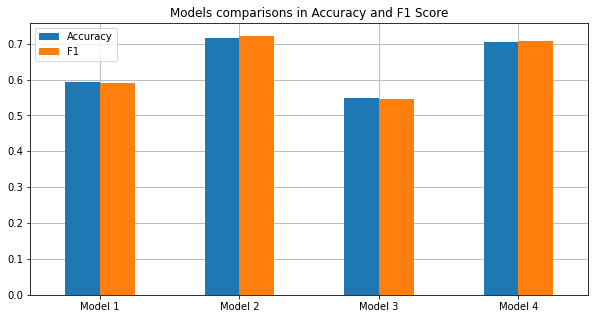

In [97]:
plt.figure()

df_result.plot(kind='bar', figsize=(10,5), zorder=2)

plt.title('Models comparisons in Accuracy and F1 Score')
plt.xticks(rotation=0)
plt.grid(zorder=0)

plt.show()

# Fine-tuning

## Model 2

In [98]:
print(model2.get_params(deep=True))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Randomised Search

In [113]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [114]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model2_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model2_rf_random = RandomizedSearchCV(estimator = model2_rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
model2_random = model2_rf_random.fit(X_glove_train, y_glove_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [124]:
print('Model2\'s Randomised Search Result:')

model2_random_accuracy = accuracy_score(model2_random.predict(X_glove_test),y_glove_test)
model2_random_f1 = f1_score(model2_random.predict(X_glove_test),y_glove_test)

print('-'*100)

print('\nTest set:')
print('Test accuracy {:.2f}'.format(model2_random_accuracy))
print('Test f1 score {:.2f}'.format(model2_random_f1))

print('-'*100)
print("The best parameters: %s" % (model2_random.best_params_))

Model2's Randomised Search Result:
----------------------------------------------------------------------------------------------------

Test set:
Test accuracy 0.75
Test f1 score 0.72
----------------------------------------------------------------------------------------------------
The best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}


### Grid Search

In [108]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [95,100,105],
    'max_features': ['auto'],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [4,5,6],
    'n_estimators': [195,200,205]
}

# Create a based model
model2_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Instantiate the grid search model
model2_rf_grid = GridSearchCV(estimator = model2_rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='f1_weighted')

model2_grid = model2_rf_grid.fit(X_glove_train, y_glove_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [123]:
print('Model2\'s Grid Search Result:')

model2_grid_accuracy = accuracy_score(model2_grid.predict(X_glove_test),y_glove_test)
model2_grid_f1 = f1_score(model2_grid.predict(X_glove_test),y_glove_test)

print('-'*100)

print('\nTest set:')
print('Test accuracy {:.2f}'.format(model2_grid_accuracy))
print('Test f1 score {:.2f}'.format(model2_grid_f1))

print('-'*100)
print("The best parameters: %s" % (model2_grid.best_params_))

Model2's Grid Search Result:
----------------------------------------------------------------------------------------------------

Test set:
Test accuracy 0.76
Test f1 score 0.72
----------------------------------------------------------------------------------------------------
The best parameters: {'bootstrap': False, 'max_depth': 95, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 195}


## Model 4

In [116]:
print(model4.get_params(deep=True))

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Randomised Search

In [117]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [118]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model4_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model4_rf_random = RandomizedSearchCV(estimator = model4_rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
model4_random = model4_rf_random.fit(X_use_train, y_use_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [122]:
print('Model2\'s Randomised Search Result:')

model4_random_accuracy = accuracy_score(model4_random.predict(X_use_test),y_use_test)
model4_random_f1 = f1_score(model4_random.predict(X_use_test),y_use_test)

print('-'*100)

print('\nTest set:')
print('Test accuracy {:.2f}'.format(model4_random_accuracy))
print('Test f1 score {:.2f}'.format(model4_random_f1))

print('-'*100)
print("The best parameters: %s" % (model4_random.best_params_))

Model2's Randomised Search Result:
----------------------------------------------------------------------------------------------------

Test set:
Test accuracy 0.77
Test f1 score 0.74
----------------------------------------------------------------------------------------------------
The best parameters: {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


### Grid Search

In [120]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [9,10,11],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [4,5,6],
    'n_estimators': [1590,1600,1610]
}

# Create a based model
model4_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Instantiate the grid search model
model4_rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='f1_weighted')

model4_grid = model4_rf_grid.fit(X_use_train, y_use_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [121]:
print('Model2\'s Grid Search Result:')

model4_grid_accuracy = accuracy_score(model4_grid.predict(X_use_test),y_use_test)
model4_grid_f1 = f1_score(model4_grid.predict(X_use_test),y_use_test)

print('-'*100)

print('\nTest set:')
print('Test accuracy {:.2f}'.format(model4_grid_accuracy))
print('Test f1 score {:.2f}'.format(model4_grid_f1))

print('-'*100)
print("The best parameters: %s" % (model4_grid.best_params_))

Model2's Grid Search Result:
----------------------------------------------------------------------------------------------------

Test set:
Test accuracy 0.77
Test f1 score 0.74
----------------------------------------------------------------------------------------------------
The best parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1590}
